# Real Estate Price Pridiction

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style("darkgrid")

## Preprocessing

### Data Understanding

Firstly, we read a data frame from the csv file.
And find out how it looks like:

In [2]:
df = pd.read_csv('../input/new-york-housing-market/NY-House-Dataset.csv')
df.head()


,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


In [3]:
print('Dataset shape: {}'.format(df.shape))

Dataset shape: (4801, 17)


It is easy to see that the table has 17 columns.

In [4]:
df['TYPE'].value_counts()

TYPE
Co-op for sale                1450
House for sale                1012
Condo for sale                 891
Multi-family home for sale     727
Townhouse for sale             299
Pending                        243
Contingent                      88
Land for sale                   49
For sale                        20
Foreclosure                     14
Condop for sale                  5
Coming Soon                      2
Mobile house for sale            1
Name: count, dtype: int64

In [5]:
df['BROKERTITLE'].value_counts()

BROKERTITLE
Brokered by COMPASS                              456
Brokered by Douglas Elliman - 575 Madison Ave    110
Brokered by Brown Harris Stevens                  93
Brokered by Corcoran East Side                    91
Brokered by RE MAX Edge                           79
                                                ... 
Brokered by Gerard R Desgranges                    1
Brokered by Property Professional Realty           1
Brokered by Mark Murphy Properties                 1
Brokered by S Sharf Realty Inc                     1
Brokered by New York Way Real Estate Corp          1
Name: count, Length: 1036, dtype: int64

In [6]:
df['STATE'].value_counts()

STATE
Brooklyn, NY 11235            102
Brooklyn, NY 11209             94
Forest Hills, NY 11375         91
Brooklyn, NY 11234             90
Staten Island, NY 10314        86
                             ... 
Queens, NY 11427                1
Queens, NY 11429                1
Long Island City, NY 11109      1
Brooklyn, NY 11694              1
Ozone Park, NY 11416            1
Name: count, Length: 308, dtype: int64

In [7]:
df['ADMINISTRATIVE_AREA_LEVEL_2'].value_counts()

ADMINISTRATIVE_AREA_LEVEL_2
United States      2484
New York           2241
New York County      21
11214                 8
Queens County         6
Kings County          6
Bronx County          5
11229                 3
10017                 2
10310                 2
10003                 2
10002                 2
10306                 2
10471                 2
11237                 1
10466                 1
Brooklyn              1
10465                 1
11412                 1
10312                 1
10309                 1
10303                 1
10463                 1
10301                 1
10304                 1
11417                 1
11414                 1
11234                 1
11218                 1
Name: count, dtype: int64

In [8]:
df['LOCALITY'].value_counts()

LOCALITY
New York           2505
New York County     979
Queens County       557
Kings County        464
Bronx County        182
Richmond County      59
United States        37
Brooklyn              6
Queens                6
The Bronx             5
Flatbush              1
Name: count, dtype: int64

In [9]:
df.dtypes

BROKERTITLE                     object
TYPE                            object
PRICE                            int64
BEDS                             int64
BATH                           float64
PROPERTYSQFT                   float64
ADDRESS                         object
STATE                           object
MAIN_ADDRESS                    object
ADMINISTRATIVE_AREA_LEVEL_2     object
LOCALITY                        object
SUBLOCALITY                     object
STREET_NAME                     object
LONG_NAME                       object
FORMATTED_ADDRESS               object
LATITUDE                       float64
LONGITUDE                      float64
dtype: object

### Data Cleaning

We can tell from the former charts that some columns have values that are too discrete strings, or contain each other, so we just need to leave the following：

```
['TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'STATE', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LATITUDE', 'LONGITUDE']
```

These attributes contain the type, size, and geographic location of the home with possible neighborhood conditions. It is easy to notice that the removed columns have a lot of redundant and repetitive geolocation information that only interfere with each other and affect the quality of the final model.

In [10]:
columns_to_keep = ['TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'STATE', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LATITUDE', 'LONGITUDE']
df = df[columns_to_keep]
df = df.dropna(subset=['PRICE', 'PROPERTYSQFT'])

### Data Modification

Using dollars as a unit would make the price too high and make the trend less obvious, so let's switch to thousands of dollars as the unit of house price.

In [11]:
df['PRICE'] = df['PRICE'] / 1000

Also, IQR can be used to remove extrenmely high price records which may be outliers.

In [12]:
Q1 = df['PRICE'].quantile(0.25)
Q3 = df['PRICE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.85 * IQR
upper_bound = Q3 + 1.85 * IQR
df = df[(df['PRICE'] >= lower_bound) & (df['PRICE'] <= upper_bound)]

### Data Quality

let see if there are duplicated or empty records:

In [13]:
print(df.duplicated().sum())
print(df.isnull().sum())

196
TYPE            0
PRICE           0
BEDS            0
BATH            0
PROPERTYSQFT    0
STATE           0
LOCALITY        0
SUBLOCALITY     0
STREET_NAME     0
LATITUDE        0
LONGITUDE       0
dtype: int64


In [14]:
distinct_counts = []

# Loop through columns
for column in df.columns:
    distinct_count = df[column].nunique()  # Use nunique() to count distinct values
    first_5_unique_values = df[column].unique()[:5]  
    last_5_unique_values = df[column].unique()[-5:]  
    distinct_counts.append({
        'Column': column, 
        'Distinct_Values_Count': distinct_count, 
        'First_5_Unique_Values': first_5_unique_values,
        'Last_5_Unique_Values': last_5_unique_values
    })

# Create a DataFrame from the list of distinct value counts
distinct_counts_df = pd.DataFrame(distinct_counts)

# Display the DataFrame with distinct value counts
distinct_counts_df.sort_values(by='Distinct_Values_Count', ascending=False,ignore_index=True)

,Column,Distinct_Values_Count,First_5_Unique_Values,Last_5_Unique_Values
0,LATITUDE,3774,"[40.761255, 40.5418051, 40.7613979, 40.6743632...","[40.816711, 40.5784496, 40.77435, 40.7458817, ..."
1,LONGITUDE,3712,"[-73.9744834, -74.1961086, -73.9746128, -73.95...","[-73.9653889, -73.94205, -73.9827389, -73.9558..."
2,PROPERTYSQFT,1218,"[1400.0, 2015.0, 445.0, 4004.0, 2184.207862]","[2681.0, 472.0, 7854.0, 903.0, 655.0]"
3,PRICE,1027,"[315.0, 260.0, 69.0, 690.0, 899.5]","[654.25, 829.999, 1058.0, 825.9, 598.125]"
4,STATE,306,"[New York, NY 10022, Staten Island, NY 10312, ...","[Queens, NY 11356, Flushing, NY 11365, New Yor..."
5,STREET_NAME,167,"[East 55th Street, Staten Island, New York, Br...","[2501, 67th Drive, Todt Hill, Saunders Street,..."
6,BEDS,21,"[2, 4, 3, 5, 1]","[13, 36, 24, 19, 18]"
7,SUBLOCALITY,20,"[Manhattan, Richmond County, New York County, ...","[Riverdale, Rego Park, Fort Hamilton, Flushing..."
8,BATH,16,"[2.0, 1.0, 2.3738608579684373, 3.0, 4.0]","[7.0, 16.0, 24.0, 0.0, 12.0]"
9,TYPE,13,"[Condo for sale, House for sale, Co-op for sal...","[Foreclosure, Pending, Coming Soon, Mobile hou..."


### Data Describing

In [15]:
df.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,932.410427,3.155292,2.128391,1871.666938,40.710776,-73.937476
std,663.047573,2.177364,1.428877,1086.053764,0.090429,0.105136
min,2.494000,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,450.000000,2.000000,1.000000,1117.000000,40.633143,-73.984867
50%,750.000000,3.000000,2.000000,2174.000000,40.721439,-73.940789
75%,1200.000000,4.000000,2.373861,2184.207862,40.771302,-73.860577
max,3300.000000,36.000000,32.000000,21000.000000,40.912729,-73.702450


### Data Definition

In [16]:
numeric_columns = ['PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE']
categorical_columns = ['TYPE', 'STATE', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME']

In [17]:
def num_combined_plot(data, x, y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the histogram with KDE
    sns.histplot(data=data, x=x, kde=True, ax=axes[0], color='coral')
    
    # Plot the scatterplot with a correlation line
    sns.regplot(data=data, x=x, y=y, ax=axes[1], color='teal', 
                scatter_kws={'edgecolor': 'white'}, line_kws={"color": "coral"})

    # Calculate the correlation coefficient
    corr_coeff = data[[x, y]].corr().iloc[0, 1]

    # Annotate the correlation coefficient on the scatter plot
    axes[1].annotate(f'Correlation : {corr_coeff:.2f}', xy=(0.65, 0.9), xycoords='axes fraction', fontsize=14, color='coral')

    # Adjust plot aesthetics
    sns.despine(bottom=True, left=True)
    axes[0].set(xlabel=f'{x}', ylabel='Frequency', title=f'{x} Distribution')
    axes[1].set(xlabel=f'{x}', ylabel=f'{y}', title=f'{x} vs {y}')
    axes[1].yaxis.set_label_position("right")
    axes[1].yaxis.tick_right()

    plt.show()

def create_subplot_grid(data, x, y):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the countplot with percentages
    sns.countplot(data=data, x=x, ax=axes[0], palette='Set2')
    axes[0].set(title=f'{x} Frequency')
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_ylabel('Count (%)')
    
    # Calculate and annotate the percentages
    total = len(data)
    for p in axes[0].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x_ = p.get_x() + p.get_width() / 2
        y_ = p.get_height()
        axes[0].annotate(percentage, (x_, y_), ha='center', va='bottom')

    # Plot the boxplot
    sns.boxplot(data=data, x=x, y=y, ax=axes[1], palette='Set2')
    axes[1].set(title=f'Price vs. {x}')
    axes[1].tick_params(axis='x', rotation=90)

    # Plot the scatterplot with colors based on x
    sns.scatterplot(data=data, x=x, y=y, ax=axes[2], hue=x, palette='Set2')
    axes[2].set(title=f'{y} vs. {x}')
    axes[2].tick_params(axis='x', rotation=90)
    axes[2].yaxis.set_label_position("right")
    
    # Add the regression line to the scatterplot
    sns.regplot(data=data, x=x, y=y, ax=axes[2], color='coral', scatter=False)
    axes[2].get_legend().remove()

    plt.tight_layout()
    plt.show()

#### Pair Plots

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

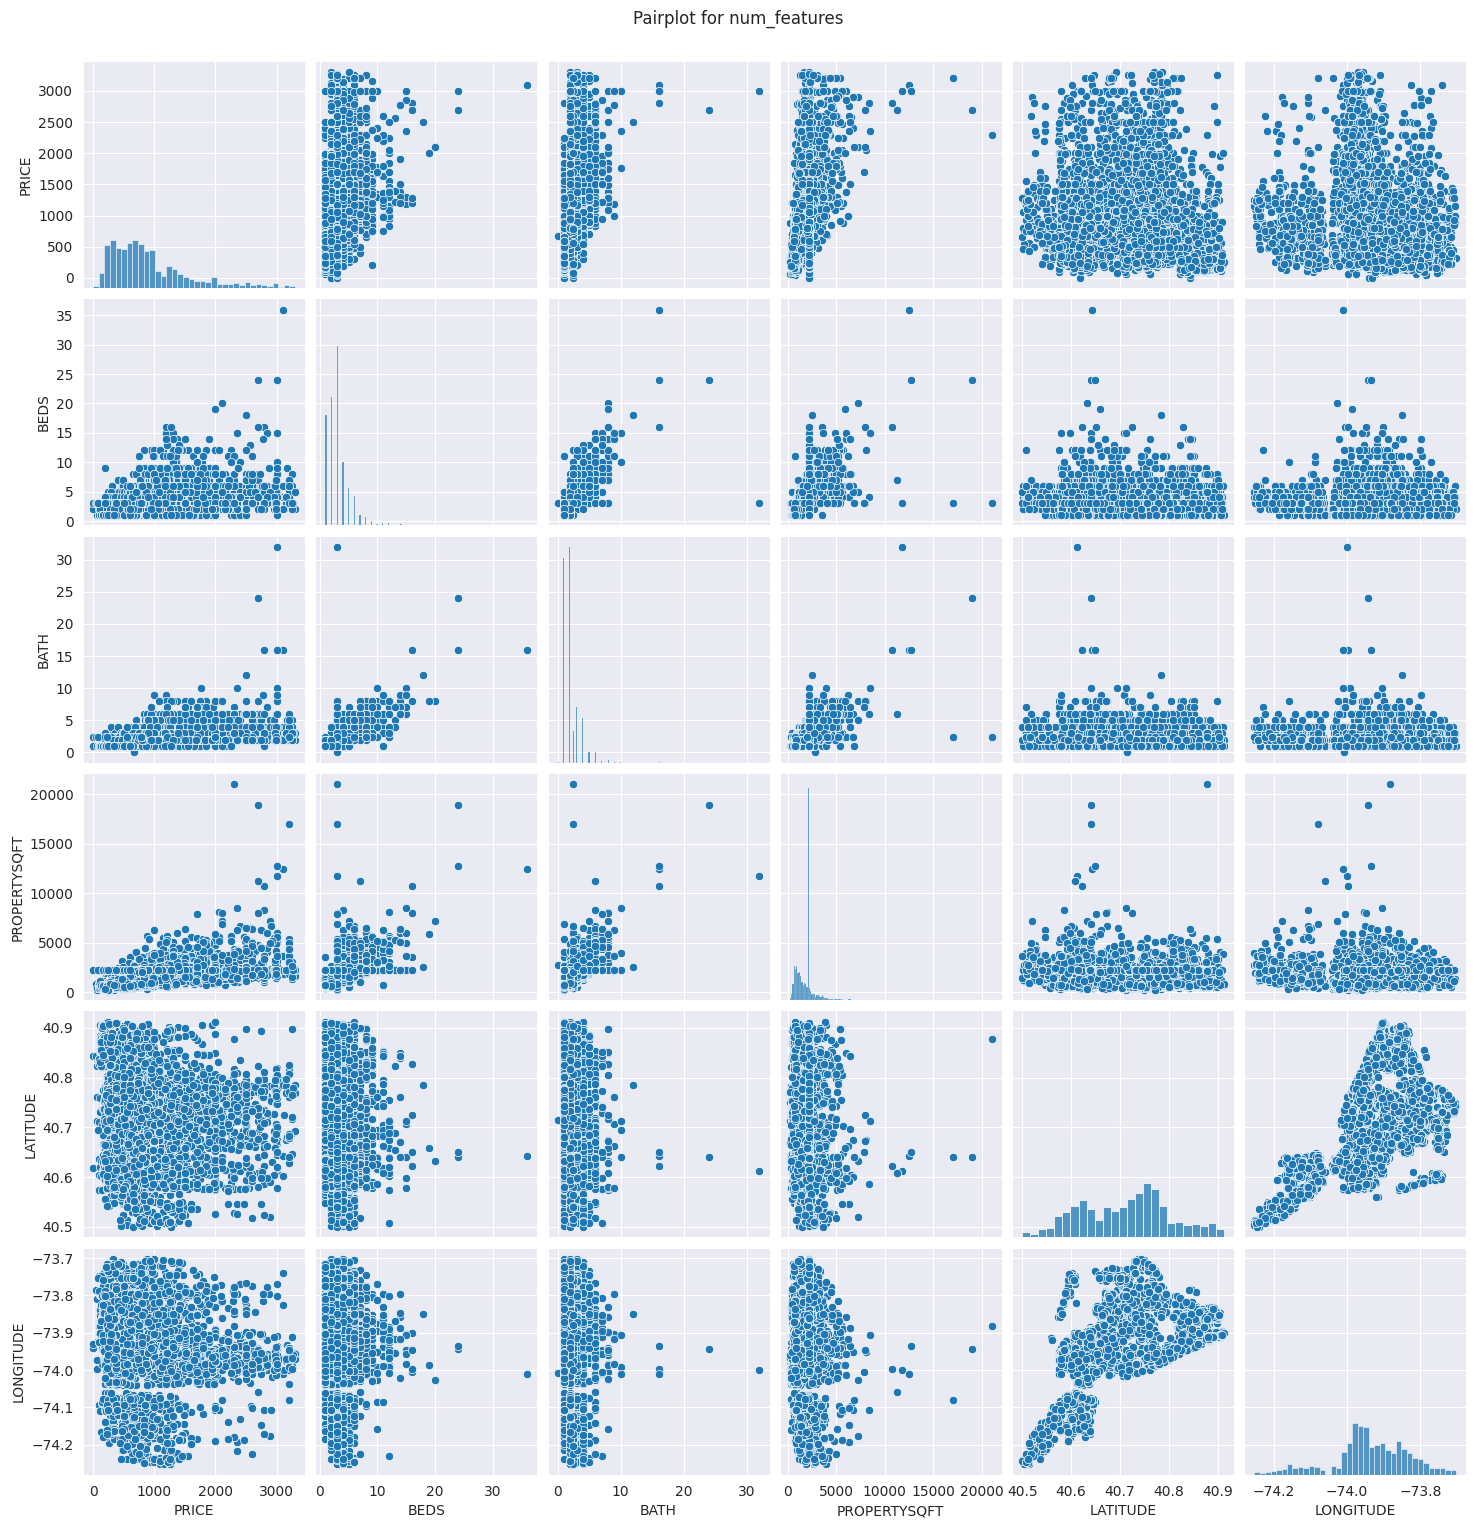

In [18]:
sns.pairplot(df[numeric_columns])
plt.suptitle('Pairplot for num_features', y=1.02)
plt.show()

#### Correlation Matrix

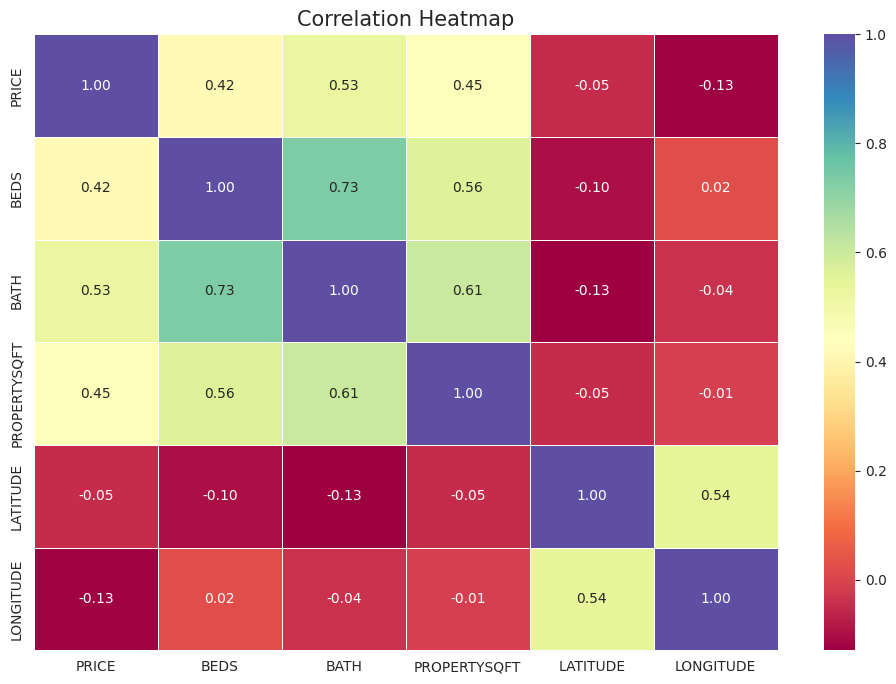

In [19]:
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='Spectral', linewidths=0.5,fmt=".2f")
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

#### Sqft_lot - Square footage of the house

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


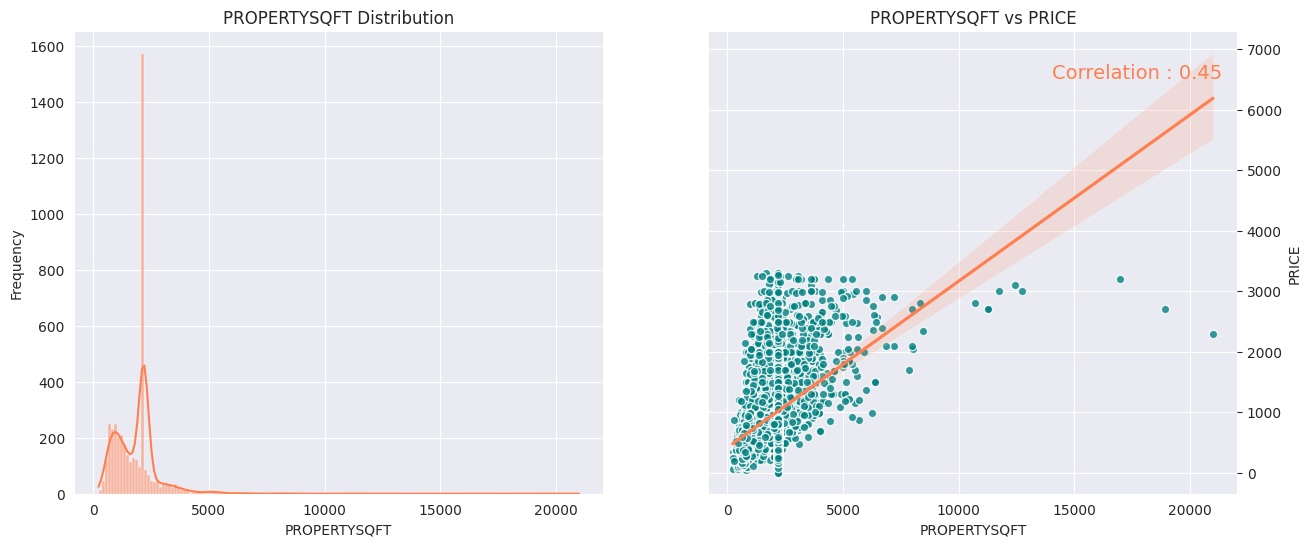

In [20]:
num_combined_plot(df,'PROPERTYSQFT','PRICE')

#### Beds_lot - #Bedroom of the house

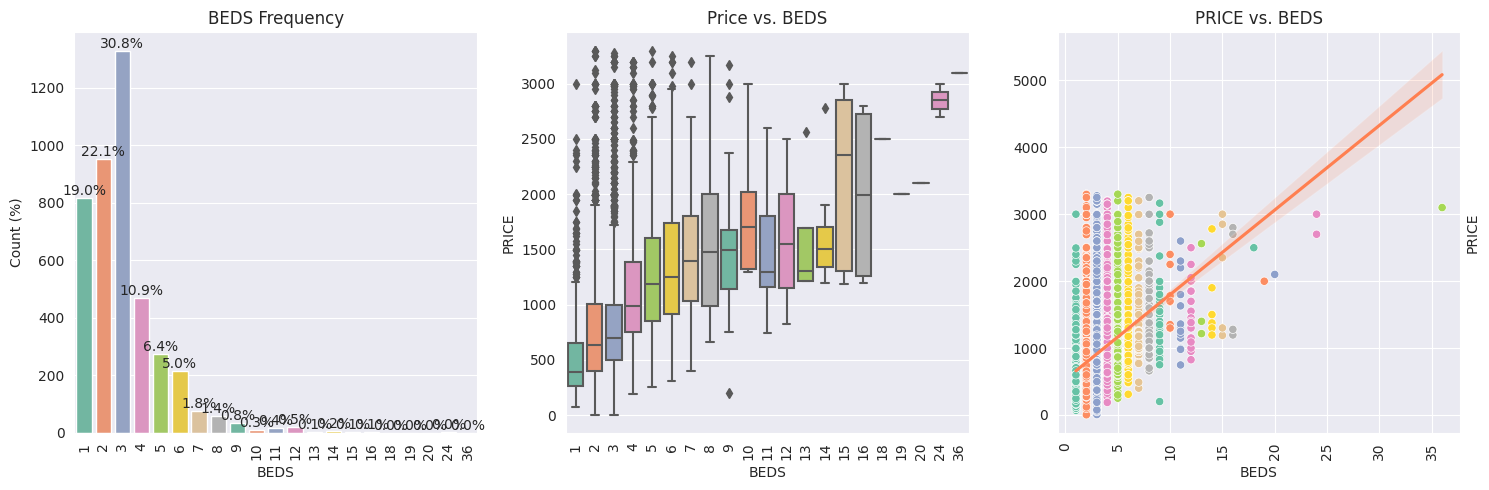

In [21]:
create_subplot_grid(df,'BEDS','PRICE')

#### Bath_plot - #Bathroom of the house

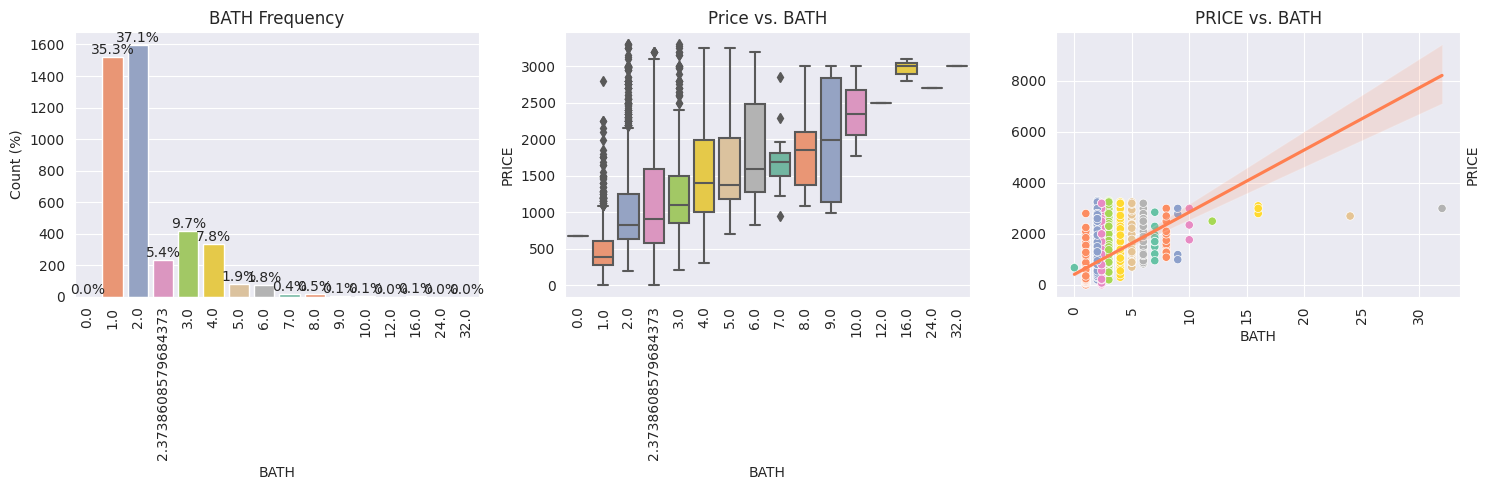

In [22]:
create_subplot_grid(df,'BATH','PRICE')

#### Location-plot

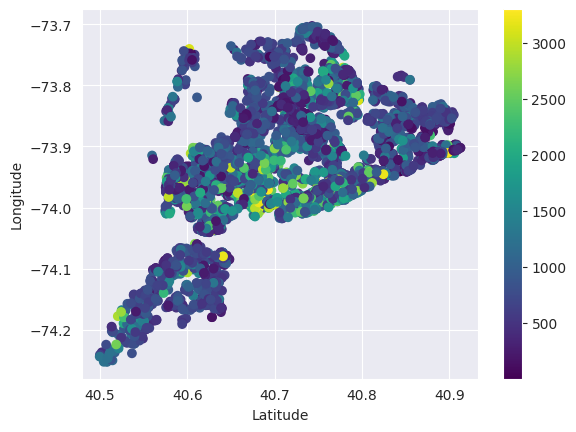

In [23]:
fig, ax = plt.subplots()
scatter = ax.scatter(df['LATITUDE'], df['LONGITUDE'], c=df['PRICE'], cmap='viridis')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
fig.colorbar(scatter)
plt.show()


## Model Setup

We first defined a preprocessor for preprocessing numerical and categorical data. 

It then defined a model that uses a **random forest regressor** as a predictor. 

Then we splited the dataset, trains the model, and predicted the test set. 

Finally, it computed the mean square error (MSE) and the coefficient of determination (R^2) to evaluate the performance of the model.

In [24]:
# numeric_columns = ['PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE'] remove PRICE

numeric_columns = ['BEDS', 'BATH', 'PROPERTYSQFT', 'LATITUDE', 'LONGITUDE']
categorical_columns = ['TYPE',  'STATE', 'LOCALITY', 'SUBLOCALITY', 'STREET_NAME']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

X = df[numeric_columns + categorical_columns]
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 101801.09347918477
R^2: 0.7825173732859598


## Evaluation

### Regression Evaluation

In [25]:
def evaluate_regression(model, X_train, y_train, X_test, y_test):
    # Predict on training and testing data
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate R-squared (R2) for training and testing data
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    
    # Calculate RMSE (Root Mean Square Error) for training and testing data
    rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
    
    # Return the evaluation metrics
    print("R-squared (R2) Train:", r2_train)
    print("R-squared (R2) Test:", r2_test)
    print("RMSE Test:", rmse_test)


In [33]:
def plot_feature_importances(model):
    importances = model.named_steps['regressor'].feature_importances_

    all_feature_names = model.named_steps['preprocessor'].get_feature_names_out()
#     print(all_feature_names)

    numeric_feature_names = [name for name in all_feature_names if name.replace('num__', '') in numeric_columns]
#     print(numeric_feature_names)

    numeric_importances = importances[:len(numeric_feature_names)]
    importances_df = pd.DataFrame({'Feature': numeric_feature_names, 'Importance': numeric_importances})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances_df, x='Feature', y='Importance', palette='Spectral_r')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Random Forest Feature Importances for Numeric Features')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()

    plt.show()


R-squared (R2) Train: 0.962268008378507
R-squared (R2) Test: 0.7825173732859598
RMSE Test: 319.0628362551564
['num__BEDS', 'num__BATH', 'num__PROPERTYSQFT', 'num__LATITUDE', 'num__LONGITUDE']


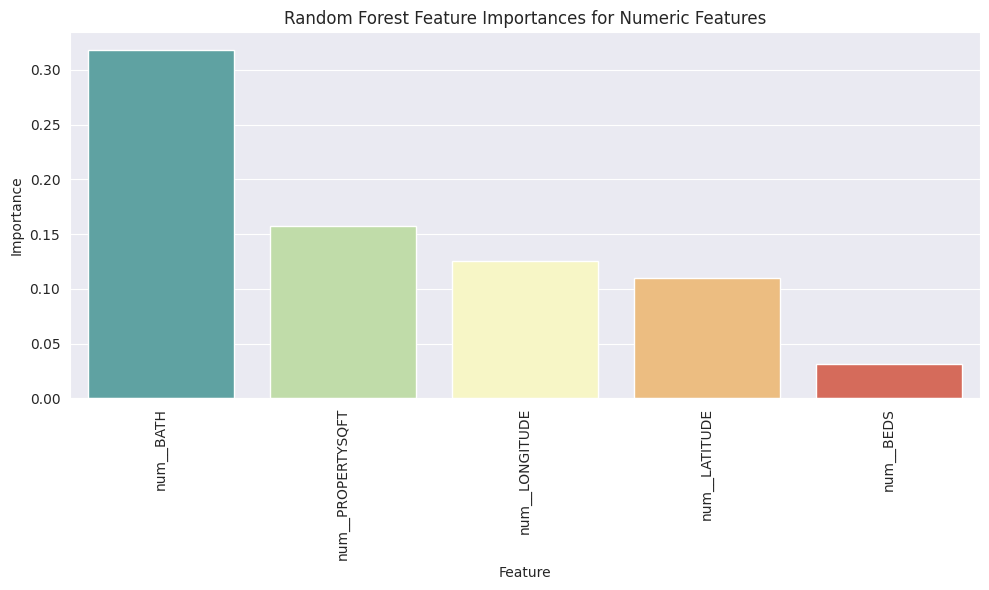

In [34]:
evaluate_regression(model, X_train, y_train, X_test, y_test)

plot_feature_importances(model)


### Make Prediction

In [36]:
new_observation = pd.DataFrame({
    'BEDS': [3],
    'BATH': [2],
    'PROPERTYSQFT': [1500],
    'LATITUDE': [40.0522],
    'LONGITUDE': [-73.2437],
    'TYPE': ['House for sale'],
    'STATE': ['New York, NY 10019'],
    'LOCALITY': ['New York'],
    'SUBLOCALITY': ['Manhattan'],
    'STREET_NAME': ['East 55th Street']
})

predicted_price = model.predict(new_observation)

print(f'Predicted price: {predicted_price[0]} k dollars.')


Predicted price: 1008.40879 k dollars.


### To summarize our work:

Data preprocessing: we first preprocessed the data, including normalizing numerical features and coding uniquely hot for categorical features.

Model training: we then trained the preprocessed data using a random forest regression model.

Model evaluation: we calculated the R^2 scores of the model on the training and test sets and the RMSE (Root Mean Squared Error) on the test set.

Feature Importance Analysis: finally, we analyzed the importance of numerical features and created a bar graph to show the importance of each numerical feature.
